In [1]:
# Setup unified medical imaging project structure
import os

# Main project root inside Kaggle's writable space
project_root = "/kaggle/working/medical-image-cnn"
os.makedirs(project_root, exist_ok=True)

# Sub-project folders
brain_root = os.path.join(project_root, "brain_mri_project")
lung_root  = os.path.join(project_root, "lung_ct_project")
skin_root  = os.path.join(project_root, "skin_cancer_project")

# Create checkpoints, logs, outputs for each
for subroot in [brain_root, lung_root, skin_root]:
    for subdir in ["checkpoints", "logs", "outputs"]:
        os.makedirs(os.path.join(subroot, subdir), exist_ok=True)

print("Project structure created successfully.")
!ls -R /kaggle/working/medical-image-cnn | head -40


Project structure created successfully.
/kaggle/working/medical-image-cnn:
brain_mri_project
lung_ct_project
skin_cancer_project

/kaggle/working/medical-image-cnn/brain_mri_project:
checkpoints
logs
outputs

/kaggle/working/medical-image-cnn/brain_mri_project/checkpoints:

/kaggle/working/medical-image-cnn/brain_mri_project/logs:

/kaggle/working/medical-image-cnn/brain_mri_project/outputs:

/kaggle/working/medical-image-cnn/lung_ct_project:
checkpoints
logs
outputs

/kaggle/working/medical-image-cnn/lung_ct_project/checkpoints:

/kaggle/working/medical-image-cnn/lung_ct_project/logs:

/kaggle/working/medical-image-cnn/lung_ct_project/outputs:

/kaggle/working/medical-image-cnn/skin_cancer_project:
checkpoints
logs
outputs

/kaggle/working/medical-image-cnn/skin_cancer_project/checkpoints:

/kaggle/working/medical-image-cnn/skin_cancer_project/logs:

/kaggle/working/medical-image-cnn/skin_cancer_project/outputs:


In [3]:
# Select which module to train/evaluate
project_choice = "brain"  # Change to "lung" or "skin" as needed

if project_choice == "brain":
    current_root = brain_root
    data_dir = "/kaggle/input/brain-mri/mri"  # must contain class folders

    # Working & persistent checkpoint paths
    checkpoint_path = os.path.join(current_root, "checkpoints", "best_brain_mri.keras")
    model_save_path = os.path.join(current_root, "outputs", "brain_mri_final.keras")

    # Optional persistent dataset (if you exported previous version)
    persistent_checkpoint = "/kaggle/input/brain-mri-trained-model/brain_mri_finetuned_persistent.keras"
    legacy_input_checkpoint = "/kaggle/input/medical-image-analysis/brain_mri_project/checkpoints/best_brain_mri.keras"

    # Prefer persistent models if available
    if os.path.exists(persistent_checkpoint):
        checkpoint_path = persistent_checkpoint
        print("Using persistent checkpoint from 'brain-mri-trained-model'")
    elif os.path.exists(legacy_input_checkpoint):
        checkpoint_path = legacy_input_checkpoint
        print("Using checkpoint from previous notebook outputs")

elif project_choice == "lung":
    current_root = lung_root
    data_dir = "/kaggle/input/<YOUR-LUNG-DATASET>/Lungs_CT_Scan/images"
    checkpoint_path = os.path.join(current_root, "checkpoints", "best_lung_ct.keras")
    model_save_path = os.path.join(current_root, "outputs", "lung_ct_final.keras")

elif project_choice == "skin":
    current_root = skin_root
    data_dir = "/kaggle/input/<YOUR-SKIN-DATASET>/Skin_Cancer"
    checkpoint_path = os.path.join(current_root, "checkpoints", "best_skin_cancer.keras")
    model_save_path = os.path.join(current_root, "outputs", "skin_cancer_final.keras")

print(f"Current project: {project_choice}")
print("Data directory:", data_dir)
print("Checkpoint path:", checkpoint_path)


Using persistent checkpoint from 'brain-mri-trained-model'
Current project: brain
Data directory: /kaggle/input/brain-mri/mri
Checkpoint path: /kaggle/input/brain-mri-trained-model/brain_mri_finetuned_persistent.keras


In [4]:
# Imports
import os, time, random, shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# In-model augmentation (used inside network)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.12),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(0.08),
], name="data_augmentation")


2025-11-12 16:13:55.784687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762964036.169104      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762964036.233416      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1762964052.677819      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
# Cell 4 - Data Generators (Corrected)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128,128)
batch_size = 16
seed = 42

# Create ImageDataGenerator with stonger augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)


# Train generator (categorical for multi-class)
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',   
    subset='training',
    shuffle=True,
    seed=seed
)

# Validation generator (categorical as well)
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical', 
    subset='validation',
    shuffle=False,
    seed=seed
)

num_classes = len(train_gen.class_indices)
class_labels = list(train_gen.class_indices.keys())

print("\n Classes detected:", class_labels)
print("Train samples:", train_gen.samples, "| Validation samples:", val_gen.samples)
print("Class indices:", train_gen.class_indices)


Found 17339 images belonging to 4 classes.
Found 4333 images belonging to 4 classes.

 Classes detected: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
Train samples: 17339 | Validation samples: 4333
Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}


In [6]:
def build_mobilenet_classifier(input_shape=(128,128,3), num_classes=4, dropout=0.7, base_trainable=False):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = base_trainable

    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.002))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ensure directories exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# try to load model
if os.path.exists(checkpoint_path):
    print(f"Loading model from checkpoint: {checkpoint_path}")
    model = load_model(checkpoint_path)
else:
    print("No checkpoint found — building new model.")
    model = build_mobilenet_classifier(input_shape=(128,128,3), num_classes=num_classes)

model.summary()


Loading model from checkpoint: /kaggle/input/brain-mri-trained-model/brain_mri_finetuned_persistent.keras


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,721,102 (25.64 MB)

 Trainable params: 2,228,996 (8.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,457,994 (17.01 MB)

In [9]:
# Base Model Training (Resume After Fine-Tuning in Same Session)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np, time, os
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Callbacks ---
checkpoint_cb = ModelCheckpoint(
    os.path.join(current_root, "checkpoints", "best_brain_mri.keras"),
    monitor='val_loss', save_best_only=True, verbose=1
)
early_cb = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)

# --- Compute Balanced Class Weights ---
classes = np.unique(train_gen.classes)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_gen.classes)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print(" Class Weights:", class_weights)

# --- Define Checkpoints ---
base_ckpt = os.path.join(current_root, "checkpoints", "best_brain_mri.keras")
fine_tuned_ckpt = os.path.join(current_root, "checkpoints", "best_brain_mri_finetuned.keras")

# --- Always Load the Latest Best Model (Even in Current Session) ---
if os.path.exists(fine_tuned_ckpt):
    print(f" Using the most recent fine-tuned model: {fine_tuned_ckpt}")
    model = load_model(fine_tuned_ckpt)
elif os.path.exists(base_ckpt):
    print(f" Using previously best saved base model: {base_ckpt}")
    model = load_model(base_ckpt)
else:
    print(" No checkpoint found — starting from scratch")

# --- Continue Training ---
epochs = 10
start_time = time.time()

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_cb, reduce_lr_cb],
    class_weight=class_weights,
    verbose=1
)

print(f" Training completed in {(time.time() - start_time)/60:.2f} minutes")

# --- Save updated version (overwrite best checkpoint) ---
model.save(base_ckpt)
print(f" Model retrained and updated at: {base_ckpt}")

 Class Weights: {0: 0.859046769718589, 1: 0.8477899471934285, 2: 1.7671218915613534, 3: 0.917019251110641}
 Using previously best saved base model: /kaggle/working/medical-image-cnn/brain_mri_project/checkpoints/best_brain_mri.keras
Epoch 1/10
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9955 - loss: 0.0196
Epoch 1: val_loss improved from inf to 0.37143, saving model to /kaggle/working/medical-image-cnn/brain_mri_project/checkpoints/best_brain_mri.keras
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 161s 128ms/step - accuracy: 0.9955 - loss: 0.0196 - val_accuracy: 0.9312 - val_loss: 0.3714 - learning_rate: 1.5000e-05
Epoch 2/10
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9950 - loss: 0.0230
Epoch 2: val_loss did not improve from 0.37143
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 134s 124ms/step - accuracy: 0.9950 - loss: 0.0230 - val_accuracy: 0.9243 - val_loss: 0.3850 - learning_rate: 1.5000e-05
Epoch 3/10
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9959 - loss: 0.0201

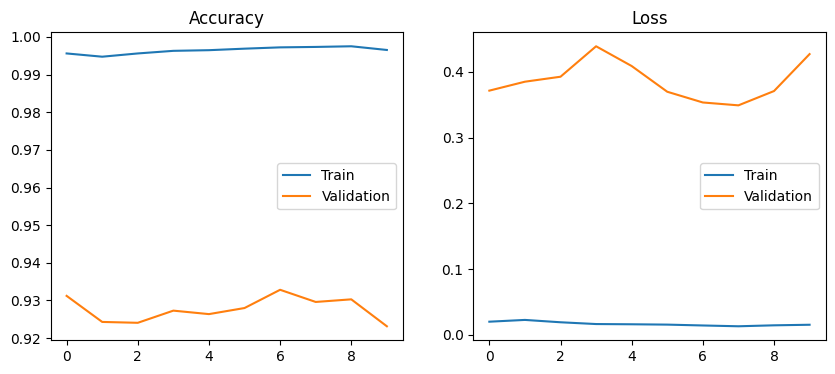

In [12]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss'); plt.legend()

plt.show()

In [11]:
# --- Fine-Tuning the MobileNetV2 Brain MRI Model (Smart Saving) ---

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import tensorflow as tf
import os, shutil

# --- Load the best saved base model ---
fine_tune_model = load_model(checkpoint_path)
print(f" Loaded best model from: {checkpoint_path}")

# --- Unfreeze top layers ---
fine_tune_at = 70
for layer in fine_tune_model.layers[-fine_tune_at:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# --- Optional Regularization ---
for layer in fine_tune_model.layers:
    if isinstance(layer, Dropout):
        layer.rate = 0.7

# --- Recompile ---
fine_tune_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Fine-Tuning ---
fine_tune_epochs = 5
fine_tune_history = fine_tune_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint_cb, early_cb, reduce_lr_cb],
    verbose=1
)

# --- Get Last Fine-Tuned Val Loss ---
last_val_loss = min(fine_tune_history.history['val_loss'])
print(f"\n Fine-tuning completed — best val_loss: {last_val_loss:.4f}")

# --- Compare with Base Model's Best Loss ---
base_best_loss = 0.3453  # (you can also load it dynamically if you saved it in a log file)
print(f" Previous best val_loss from base model: {base_best_loss:.4f}")

# --- Save Logic (Safe Write) ---
import shutil, os

# If checkpoint path is in read-only /kaggle/input, redirect to /kaggle/working
if checkpoint_path.startswith("/kaggle/input/"):
    checkpoint_path = os.path.join(current_root, "checkpoints", "best_brain_mri.keras")

# Compare and save if improved
if last_val_loss < base_best_loss:
    fine_tune_model.save(checkpoint_path)
    print(f" Fine-tuned model improved (↓{base_best_loss:.4f} → ↓{last_val_loss:.4f}) — saved as new best.")
    
    # Make an immutable copy for future reuse
    finetuned_copy = os.path.join(current_root, "checkpoints", "best_brain_mri_finetuned.keras")
    shutil.copy(checkpoint_path, finetuned_copy)
    print(f" Immutable fine-tuned copy created at: {finetuned_copy}")
else:
    print(f" Fine-tuned model did NOT improve (↑{last_val_loss:.4f}) — keeping base model as best.")


 Loaded best model from: /kaggle/input/brain-mri-trained-model/brain_mri_finetuned_persistent.keras
Epoch 1/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9955 - loss: 0.0203
Epoch 1: val_loss did not improve from 0.34906
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 164s 126ms/step - accuracy: 0.9955 - loss: 0.0203 - val_accuracy: 0.9296 - val_loss: 0.3804 - learning_rate: 1.0000e-05
Epoch 2/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9967 - loss: 0.0177
Epoch 2: val_loss improved from 0.34906 to 0.34500, saving model to /kaggle/working/medical-image-cnn/brain_mri_project/checkpoints/best_brain_mri.keras
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 136s 125ms/step - accuracy: 0.9967 - loss: 0.0177 - val_accuracy: 0.9291 - val_loss: 0.3450 - learning_rate: 1.0000e-05
Epoch 3/5
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9964 - loss: 0.0190
Epoch 3: val_loss did not improve from 0.34500
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 135s 125ms/step - accuracy: 0.9964 - loss: 0.0190 - v

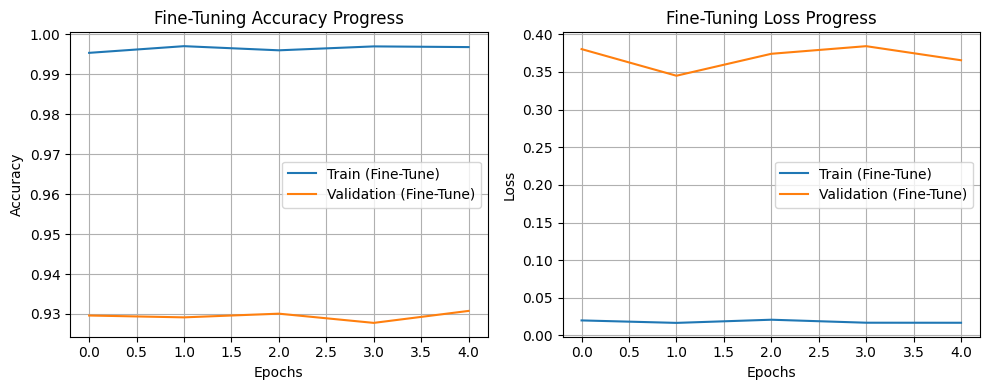

In [13]:
# Compare Training vs Validation (Fine-Tuned Phase)
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train (Fine-Tune)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation (Fine-Tune)')
plt.title('Fine-Tuning Accuracy Progress')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train (Fine-Tune)')
plt.plot(fine_tune_history.history['val_loss'], label='Validation (Fine-Tune)')
plt.title('Fine-Tuning Loss Progress')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Export Latest Best Model Safely (Persistent Copy)

import os, shutil

# --- Create export directory ---
export_dir = "/kaggle/working/exported_models"
os.makedirs(export_dir, exist_ok=True)

# --- Define checkpoints ---
base_ckpt = os.path.join(current_root, "checkpoints", "best_brain_mri.keras")
fine_tuned_ckpt = os.path.join(current_root, "checkpoints", "best_brain_mri_finetuned.keras")

# --- Smart export logic ---
if os.path.exists(fine_tuned_ckpt):
    source_model = fine_tuned_ckpt
    print(" Exporting fine-tuned model...")
elif os.path.exists(base_ckpt):
    source_model = base_ckpt
    print(" Fine-tuned model not found — exporting best base model instead...")
else:
    raise FileNotFoundError(" No trained model found to export. Please run training first.")

# --- Copy the selected model ---
exported_model_path = os.path.join(export_dir, "brain_mri_finetuned_persistent.keras")
shutil.copy(source_model, exported_model_path)
print(f" Model copied to: {exported_model_path}")

# --- Create a ZIP archive for Kaggle dataset upload ---
zip_path = "/kaggle/working/brain_mri_trained_model"
shutil.make_archive(zip_path, 'zip', export_dir)

print("\n Export ready → check 'brain_mri_trained_model.zip' in Files panel.")
print(" To keep it for future sessions: click Save Version → Output Only.")
print(" Later, upload this ZIP as a dataset named 'brain-mri-trained-model'.")


 Exporting fine-tuned model...
 Model copied to: /kaggle/working/exported_models/brain_mri_finetuned_persistent.keras

 Export ready → check 'brain_mri_trained_model.zip' in Files panel.
 To keep it for future sessions: click Save Version → Output Only.
 Later, upload this ZIP as a dataset named 'brain-mri-trained-model'.


Evaluating model: Fine-tuned
271/271 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step

 Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.91      0.92      1261
meningioma_tumor       0.94      0.90      0.92      1278
          normal       0.91      0.99      0.95       613
 pituitary_tumor       0.95      0.97      0.96      1181

        accuracy                           0.93      4333
       macro avg       0.93      0.94      0.94      4333
    weighted avg       0.93      0.93      0.93      4333


 Overall Validation Accuracy: 93.40%


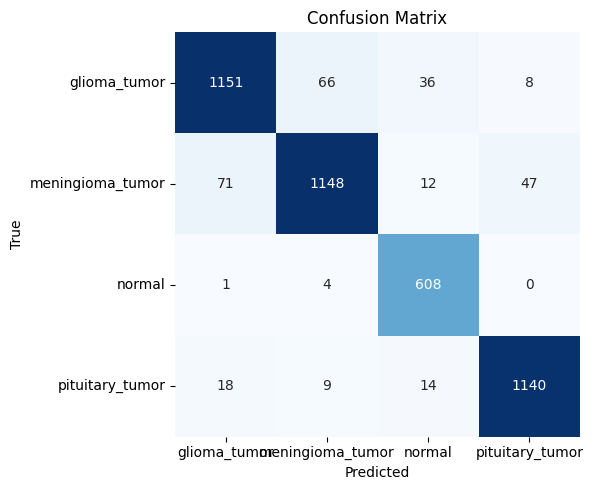

In [15]:
#  Model Evaluation (Post Fine-Tuning)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select model to evaluate (fine-tuned if available)
eval_model = fine_tune_model if 'fine_tune_model' in locals() else model
print(f"Evaluating model: {'Fine-tuned' if eval_model == fine_tune_model else 'Base model'}")

#  Generate predictions
y_pred = eval_model.predict(val_gen, verbose=1)
y_true = val_gen.classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Overall Accuracy
test_acc = np.mean(y_pred_classes == y_true)
print(f"\n Overall Validation Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels, yticklabels=class_labels, cbar=False, norm=None)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


 Using model for prediction: /kaggle/working/medical-image-cnn/brain_mri_project/checkpoints/best_brain_mri.keras

 Prediction probabilities:
 - glioma_tumor        : 0.9992
 - meningioma_tumor    : 0.0008
 - normal              : 0.0000
 - pituitary_tumor     : 0.0000


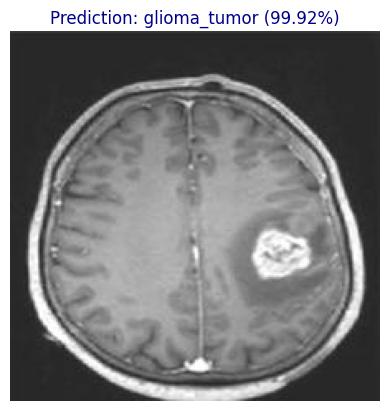

In [20]:
# Single Image Prediction (Final & Robust Version)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Auto-select latest available model
if os.path.exists(checkpoint_path):
    model_path_to_use = checkpoint_path
elif os.path.exists(os.path.join(current_root, "outputs", "best_brain_mri.keras")):
    model_path_to_use = os.path.join(current_root, "outputs", "best_brain_mri.keras")
else:
    raise FileNotFoundError(" No trained model found. Please train or fine-tune first!")

print(f" Using model for prediction: {model_path_to_use}")
predict_model = load_model(model_path_to_use)

# Choose test image path (you can upload your own too)
fname = "/kaggle/input/test-brain-mri/test-mri-image/G_46_BR_.jpg"

if not os.path.exists(fname):
    raise FileNotFoundError(f" Test image not found: {fname}\nPlease check your dataset path.")

# Preprocess the image
img = cv2.imread(fname)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (128, 128)).astype("float32") / 255.0
img_resized = np.expand_dims(img_resized, axis=0)

# Predict
pred = predict_model.predict(img_resized, verbose=0)[0]
label_idx = np.argmax(pred)
label = class_labels[label_idx]
confidence = np.max(pred)

# Print prediction probabilities
print("\n Prediction probabilities:")
for lbl, prob in zip(class_labels, pred):
    print(f" - {lbl:20s}: {prob:.4f}")

# Warn if model is unsure
if confidence < 0.6:
    print(f"\n Low confidence ({confidence*100:.2f}%). Model might be uncertain about this prediction.")

# Display result
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Prediction: {label} ({confidence*100:.2f}%)", fontsize=12, color="darkblue")
plt.show()
